This section provides a script to generated curated data fitted for analysis. This notebook runtime are quite long due to complexity. Increase spark config for smoother performance

In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, when, expr, format_number, dayofweek
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
from pyspark.ml.stat import Correlation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("CuratedData")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '8g')
    .config('spark.executor.memory', '8g')
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/25 14:45:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Importing ultilities function defined in `scripts` directory for analysis

In [2]:
import sys
sys.path.insert(0, '../scripts')
from utils import dropNull, filteringOnCondition, featureExtracting, extractingDateAndTime, reFormat, joiningWeatherData, joiningBoroughs
from featureEngineering import encodingTime, isPeakHour, calculateTimeTravel, normalizationFeature, isWeekend

In [3]:
raw_data = spark.read.parquet('../data/raw/*')
raw_data.count()

18816606

Check null values and dropped all

In [4]:
null_counts = raw_data.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in raw_data.columns])
null_counts.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|ratecodeid|store_and_fwd_flag|pulocationid|dolocationid|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|         780804|            0|    780804|            780804|           0|           0|           0|          0|    0|      0|         

In [5]:
curated_data = dropNull(raw_data)
curated_data.count()

18035802

Filtering invalid records, refer to `../scripts/ultils.py`

In [6]:
curated_data = filteringOnCondition(curated_data)
curated_data.show(10)


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+
|vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|ratecodeid|store_and_fwd_flag|pulocationid|dolocationid|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|is_valid_record|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+---------------+
|       1| 2023-07-01 00:29:59|  2023-07-01 00:40:15|              1|          1.8|         1|                 N|         140|         263|

Initial correlation heatmap between numerical features

24/08/25 14:45:32 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
24/08/25 14:45:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/08/25 14:45:36 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


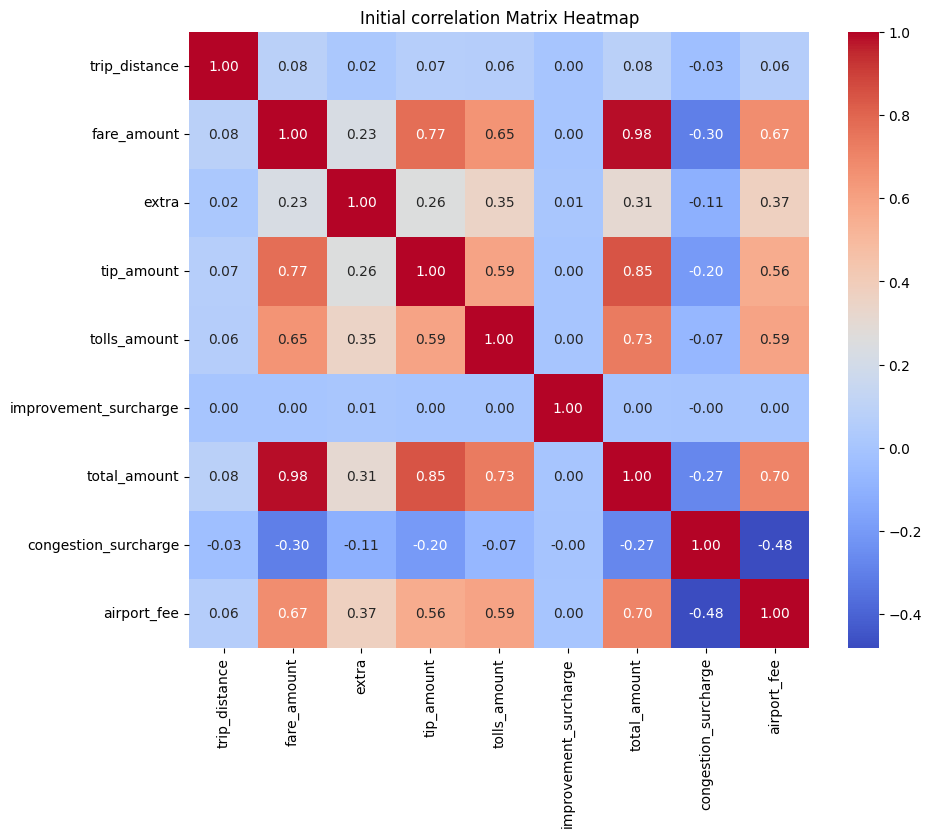

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

columns = [
    'trip_distance', 'fare_amount', 'extra', 'tip_amount', 'tolls_amount', 
    'improvement_surcharge','total_amount', 'congestion_surcharge', 'airport_fee'
]
#Calulating correlation matrix
features = "correlation_features"
assembler = VectorAssembler(inputCols=columns, outputCol=features)
feature_vector = assembler.transform(curated_data.dropna('any')).select(features)
corr_matrix = Correlation.corr(feature_vector, features).head()[0]
corr_matrix_dense = corr_matrix.toArray()


#Visualize using seaborn/matplotlib
corr_df = pd.DataFrame(corr_matrix_dense, columns=columns, index=columns)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Initial correlation Matrix Heatmap")
plt.savefig('../plots/initial_correlation_matrix.png', format='png')
plt.show()

Extracting necessary features, refer to `../scripts/ultils.py`

In [8]:
curated_data = featureExtracting(curated_data)
curated_data = extractingDateAndTime(curated_data)
curated_data.show(10, truncate=100)


+--------------------+--------+------+-------+---------------------+-------------+------------+-----------+----------+
|tpep_pickup_datetime|pu_month|pu_day|pu_hour|tpep_dropoff_datetime|trip_distance|pulocationid|fare_amount|tip_amount|
+--------------------+--------+------+-------+---------------------+-------------+------------+-----------+----------+
| 2023-07-01 00:29:59|       7|     1|      0|  2023-07-01 00:40:15|          1.8|         140|       12.1|       5.1|
| 2023-07-01 00:38:29|       7|     1|      0|  2023-07-01 00:48:53|         2.36|         142|       13.5|       3.7|
| 2023-07-01 00:14:16|       7|     1|      0|  2023-07-01 00:29:13|         4.36|          68|       19.8|      4.96|
| 2023-07-01 00:29:32|       7|     1|      0|  2023-07-01 00:54:14|         8.67|         138|       38.7|       7.0|
| 2023-07-01 00:24:43|       7|     1|      0|  2023-07-01 00:47:49|         9.11|         138|       39.4|     11.19|
| 2023-07-01 00:35:28|       7|     1|      0|  

Generating new features, refer to `../scripts/featureEngineering.py`

In [9]:
#Generating trip_duration features
curated_data = calculateTimeTravel(curated_data)

Generating indicator features (isWeekend and isPeakHour)

In [10]:
curated_data  = isWeekend(curated_data)
curated_data = isPeakHour(curated_data)
curated_data.show(10)



+--------------------+--------+------+-------+---------------------+-------------+------------+-----------+----------+---------------------+----------+------------+
|tpep_pickup_datetime|pu_month|pu_day|pu_hour|tpep_dropoff_datetime|trip_distance|pulocationid|fare_amount|tip_amount|trip_duration_minutes|is_weekend|is_peak_hour|
+--------------------+--------+------+-------+---------------------+-------------+------------+-----------+----------+---------------------+----------+------------+
| 2023-07-01 00:29:59|       7|     1|      0|  2023-07-01 00:40:15|          1.8|         140|       12.1|       5.1|   10.266666666666667|         1|           0|
| 2023-07-01 00:38:29|       7|     1|      0|  2023-07-01 00:48:53|         2.36|         142|       13.5|       3.7|                 10.4|         1|           0|
| 2023-07-01 00:14:16|       7|     1|      0|  2023-07-01 00:29:13|         4.36|          68|       19.8|      4.96|                14.95|         1|           0|
| 2023-07-

Merging dataset with zones and weather according to date and time

In [11]:
taxi_zones_df = spark.read.csv('../data/taxi_zones/taxi+_zone_lookup.csv', header=True, inferSchema=True)
taxi_zones_df = taxi_zones_df.withColumnRenamed('LocationID', 'pulocationid')
curated_data = joiningBoroughs(curated_data,taxi_zones_df)
curated_data.show(10)


+------------+--------------------+--------+------+-------+---------------------+-------------+-----------+----------+---------------------+----------+------------+-----------------+
|pulocationid|tpep_pickup_datetime|pu_month|pu_day|pu_hour|tpep_dropoff_datetime|trip_distance|fare_amount|tip_amount|trip_duration_minutes|is_weekend|is_peak_hour|      pu_location|
+------------+--------------------+--------+------+-------+---------------------+-------------+-----------+----------+---------------------+----------+------------+-----------------+
|         140| 2023-07-01 00:29:59|       7|     1|      0|  2023-07-01 00:40:15|          1.8|       12.1|       5.1|   10.266666666666667|         1|           0|        Manhattan|
|         142| 2023-07-01 00:38:29|       7|     1|      0|  2023-07-01 00:48:53|         2.36|       13.5|       3.7|                 10.4|         1|           0|        Manhattan|
|          68| 2023-07-01 00:14:16|       7|     1|      0|  2023-07-01 00:29:13|    

In [12]:
curated_data = curated_data.withColumn("tpep_pickup_datetime", F.date_format("tpep_pickup_datetime", "yyyy-MM-dd"))
weather_df = spark.read.csv("../data/hourly_weather_2023.csv", header=True, inferSchema=True)
curated_data = joiningWeatherData(curated_data, weather_df)
curated_data = dropNull(curated_data)

In [13]:
curated_data.show(10)

+------------+--------------------+--------+------+-------+---------------------+-------------+-----------+----------+---------------------+----------+------------+-----------------+----------+----+----------+---------+--------------------+-----------+
|pulocationid|tpep_pickup_datetime|pu_month|pu_day|pu_hour|tpep_dropoff_datetime|trip_distance|fare_amount|tip_amount|trip_duration_minutes|is_weekend|is_peak_hour|      pu_location|      date|hour|wind_speed|dew_point|atmospheric_pressure|temperature|
+------------+--------------------+--------+------+-------+---------------------+-------------+-----------+----------+---------------------+----------+------------+-----------------+----------+----+----------+---------+--------------------+-----------+
|         140|          2023-07-01|       7|     1|      0|  2023-07-01 00:40:15|          1.8|       12.1|       5.1|   10.266666666666667|         1|           0|        Manhattan|2023-07-01|   0|       0.0|     13.3|              1017.1| 

Standardization of features using StandardScaler()

In [14]:

columnsNormalize = ['wind_speed', 'dew_point','atmospheric_pressure','temperature', 'trip_duration_minutes','fare_amount']

# UDF to extract the first element from the scaled vector
extract_element_udf = udf(lambda vector: float(vector[0]), DoubleType())

for col_name in columnsNormalize:
    # Assemble the column into a vector
    assembler = VectorAssembler(inputCols=[col_name], outputCol=f"{col_name}_vec")
    temp_df = assembler.transform(curated_data)
    
    # Apply StandardScaler
    scaler = StandardScaler(
        inputCol=f"{col_name}_vec",
        outputCol=f"{col_name}_scaled_vec",
        withStd=True,
        withMean=True
    )
    scaler_model = scaler.fit(temp_df)
    scaled_col_df = scaler_model.transform(temp_df)
    
    # Extract the scaled value from the vector
    scaled_col_df = scaled_col_df.withColumn(f"{col_name}_scaled", extract_element_udf(col(f"{col_name}_scaled_vec")))
    
    # Drop the intermediate vector columns
    curated_data = scaled_col_df.drop(f"{col_name}_vec", f"{col_name}_scaled_vec")

# Show the resulting DataFrame with all scaled features
curated_data.show(truncate=False)


+------------+--------------------+--------+------+-------+---------------------+-------------+-----------+----------+---------------------+----------+------------+-----------------+----------+----+----------+---------+--------------------+-----------+-------------------+-------------------+---------------------------+------------------+----------------------------+---------------------+
|pulocationid|tpep_pickup_datetime|pu_month|pu_day|pu_hour|tpep_dropoff_datetime|trip_distance|fare_amount|tip_amount|trip_duration_minutes|is_weekend|is_peak_hour|pu_location      |date      |hour|wind_speed|dew_point|atmospheric_pressure|temperature|wind_speed_scaled  |dew_point_scaled   |atmospheric_pressure_scaled|temperature_scaled|trip_duration_minutes_scaled|fare_amount_scaled   |
+------------+--------------------+--------+------+-------+---------------------+-------------+-----------+----------+---------------------+----------+------------+-----------------+----------+----+----------+---------

Reformat the dataset for ease of navigation

In [15]:
curated_data = reFormat(curated_data)
curated_data.show(10)

+------------+-----------------+--------+------+-------+----------+------------+----------------------------+-------------+------------------+-----------------+----------------+---------------------------+------------------+----------+
|pulocationid|      pu_location|pu_month|pu_day|pu_hour|is_weekend|is_peak_hour|trip_duration_minutes_scaled|trip_distance|fare_amount_scaled|wind_speed_scaled|dew_point_scaled|atmospheric_pressure_scaled|temperature_scaled|tip_amount|
+------------+-----------------+--------+------+-------+----------+------------+----------------------------+-------------+------------------+-----------------+----------------+---------------------------+------------------+----------+
|         140|        Manhattan|       7|     1|      0|         1|           0|                     -0.2074|          1.8|           -0.4772|          -1.2992|          0.4422|                     0.1008|            0.8325|       5.1|
|         142|        Manhattan|       7|     1|      0|

In [16]:
save_dir = "../data/curated/"
file_path = f"{save_dir}Dataset.parquet"

# Save the entire dataset
curated_data.write.mode("overwrite").parquet(file_path)
print(f"Dataset saved to {file_path}")

Dataset saved to ../data/curated/Dataset.parquet


In [17]:
#Final dataset shape
print(curated_data.count())
curated_data.columns


13291101


['pulocationid',
 'pu_location',
 'pu_month',
 'pu_day',
 'pu_hour',
 'is_weekend',
 'is_peak_hour',
 'trip_duration_minutes_scaled',
 'trip_distance',
 'fare_amount_scaled',
 'wind_speed_scaled',
 'dew_point_scaled',
 'atmospheric_pressure_scaled',
 'temperature_scaled',
 'tip_amount']